In [1]:
pip install numpy pandas matplotlib scikit-learn tensorflow imbalanced-learn joblib

Note: you may need to restart the kernel to use updated packages.


Data loaded. Shape: (14988, 17)

Tuning RandomForest...


C:\Users\cam71\AppData\Local\Temp\ipykernel_1844\3860146931.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TEMP_DIFF'] = df['MAX_TEMP'] - df['MIN_TEMP']
C:\Users\cam71\AppData\Local\Temp\ipykernel_1844\3860146931.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SEASON"] = LabelEncoder().fit_transform(df["SEASON"])


Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 350}

Tuning GradientBoosting...
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}

Tuning LogisticRegression...
Best Params: {'C': 1.0, 'solver': 'liblinear'}

--- RandomForest Evaluation ---
Confusion Matrix:
 [[937  42]
 [ 83  78]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       979
           1       0.65      0.48      0.56       161

    accuracy                           0.89      1140
   macro avg       0.78      0.72      0.75      1140
weighted avg       0.88      0.89      0.88      1140

ROC AUC Score: 0.8638837957352857
Test Accuracy: 0.8903508771929824

--- GradientBoosting Evaluation ---
Confusion Matrix:
 [[940  39]
 [ 83  78]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       979
           1       0.67      0.48  

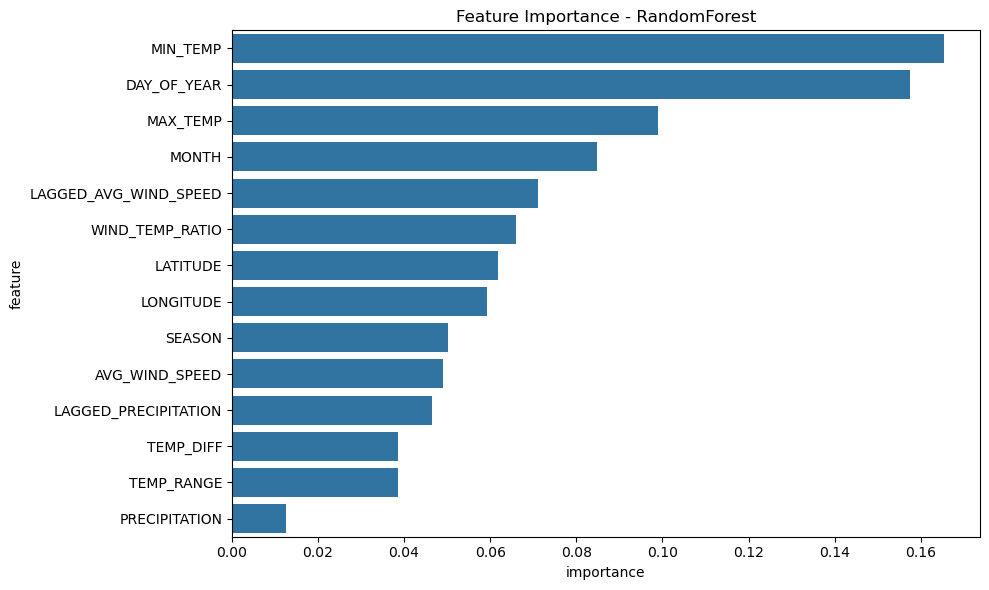

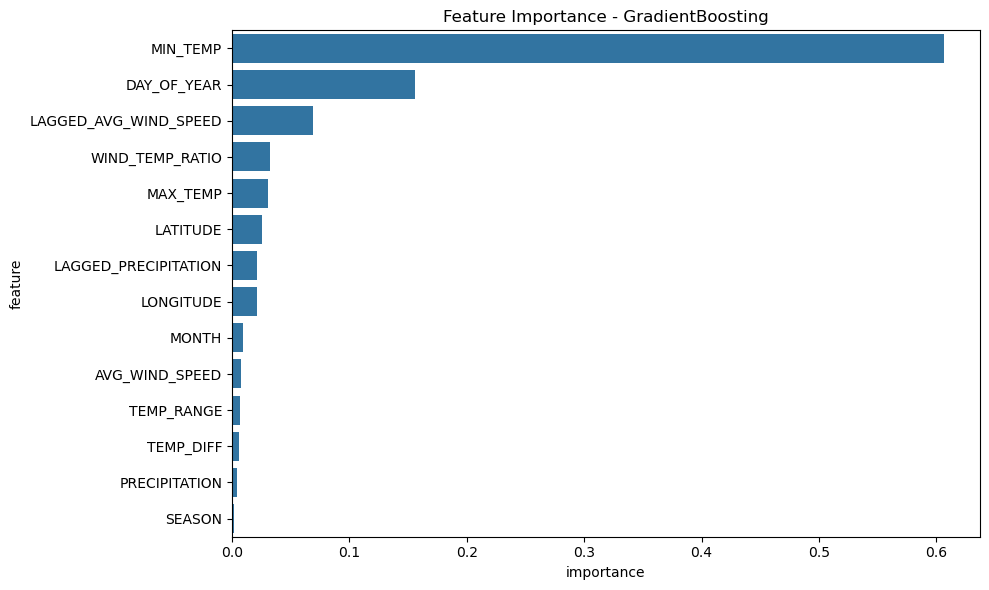

c:\Users\cam71\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\cam71\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\cam71\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training FeedforwardNN ---
Epoch 1 - Loss: 0.3255, Accuracy: 0.8618, AUC: 0.8166, Val_Loss: 0.2907, Val_Accuracy: 0.8912, Val_AUC: 0.8560
Epoch 2 - Loss: 0.2941, Accuracy: 0.8782, AUC: 0.8526, Val_Loss: 0.2851, Val_Accuracy: 0.8904, Val_AUC: 0.8641
Epoch 3 - Loss: 0.2897, Accuracy: 0.8859, AUC: 0.8578, Val_Loss: 0.2797, Val_Accuracy: 0.8930, Val_AUC: 0.8685
Epoch 4 - Loss: 0.2861, Accuracy: 0.8859, AUC: 0.8634, Val_Loss: 0.2774, Val_Accuracy: 0.8930, Val_AUC: 0.8710
Epoch 5 - Loss: 0.2865, Accuracy: 0.8857, AUC: 0.8612, Val_Loss: 0.2756, Val_Accuracy: 0.8965, Val_AUC: 0.8725
Epoch 6 - Loss: 0.2812, Accuracy: 0.8879, AUC: 0.8663, Val_Loss: 0.2753, Val_Accuracy: 0.8982, Val_AUC: 0.8723
Epoch 7 - Loss: 0.2796, Accuracy: 0.8870, AUC: 0.8655, Val_Loss: 0.2746, Val_Accuracy: 0.8965, Val_AUC: 0.8725
Epoch 8 - Loss: 0.2769, Accuracy: 0.8874, AUC: 0.8738, Val_Loss: 0.2743, Val_Accuracy: 0.8939, Val_AUC: 0.8730
Epoch 9 - Loss: 0.2760, Accuracy: 0.8896, AUC: 0.8724, Val_Loss: 0.2738, Val_Acc

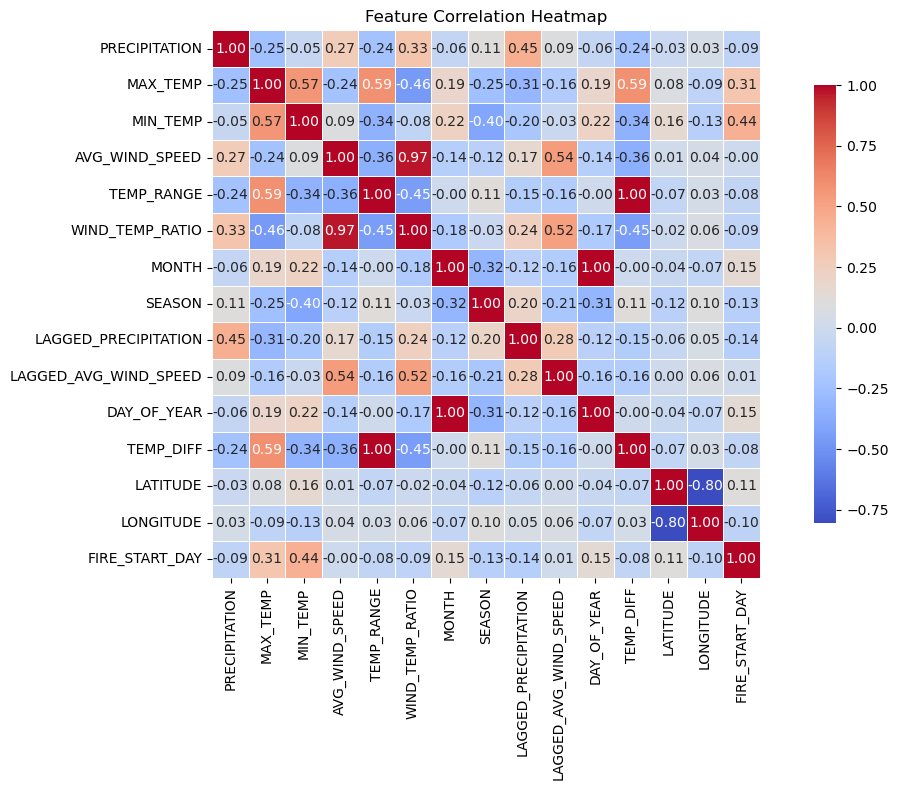

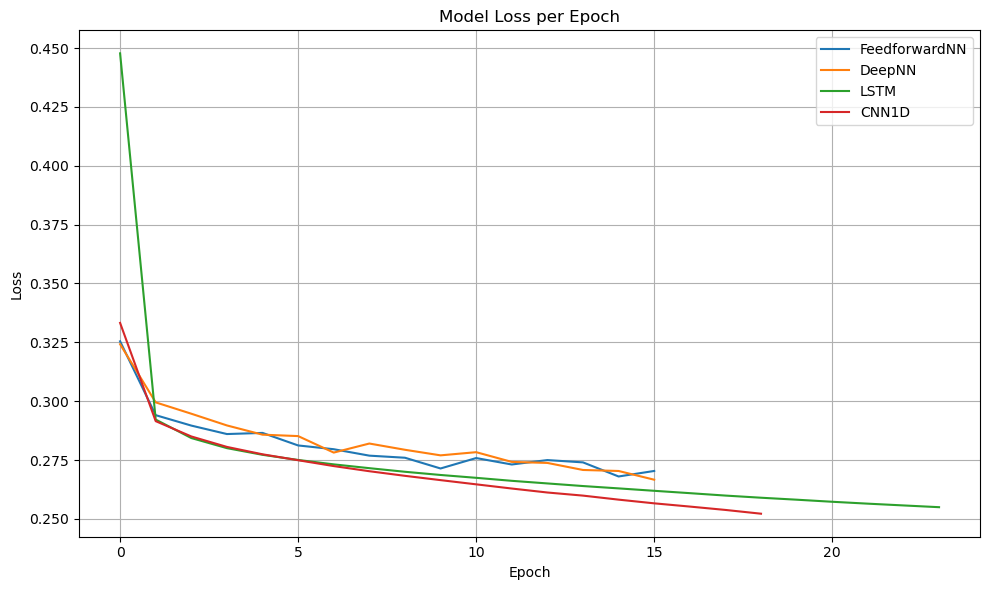

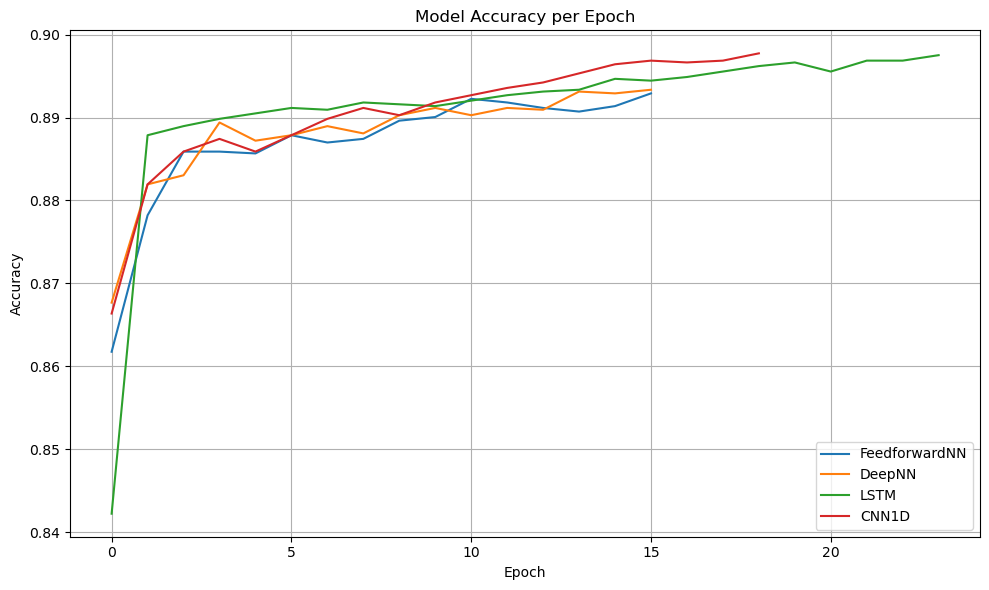

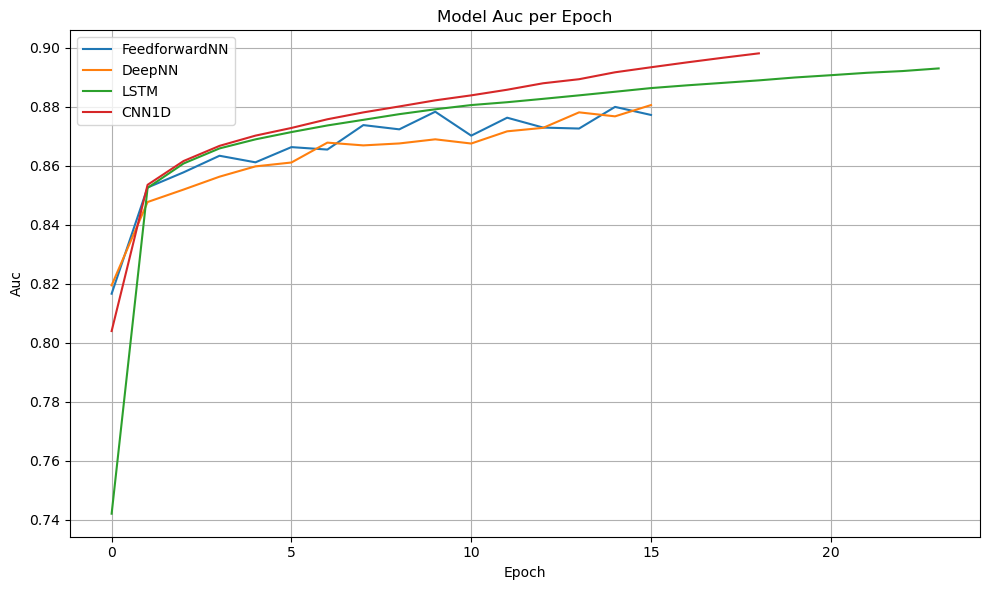

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, Callback

import geopandas as gpd
from shapely.geometry import Point

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --- Logging callback for deep learning training ---
class TrainingLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch+1} - Loss: {logs.get('loss'):.4f}, "
              f"Accuracy: {logs.get('accuracy'):.4f}, AUC: {logs.get('auc'):.4f}, "
              f"Val_Loss: {logs.get('val_loss'):.4f}, "
              f"Val_Accuracy: {logs.get('val_accuracy'):.4f}, "
              f"Val_AUC: {logs.get('val_auc'):.4f}")

# ---- Data loading and geospatial join ----
def load_data(filepath):
    df = pd.read_csv(filepath, parse_dates=["DATE"])
    print(f"Data loaded. Shape: {df.shape}")
    return df

def load_geospatial_data(filepath, lat_col='LATITUDE', lon_col='LONGITUDE'):
    geo_df = pd.read_csv(filepath)
    geo_df = geo_df.dropna(subset=[lat_col, lon_col])
    geometry = gpd.points_from_xy(geo_df[lon_col], geo_df[lat_col])
    gdf = gpd.GeoDataFrame(geo_df, geometry=geometry, crs='EPSG:4326')
    print(f"Geospatial data loaded. Shape: {gdf.shape}")
    return gdf

def preprocess_data(df):
    df = df.dropna()
    df['TEMP_DIFF'] = df['MAX_TEMP'] - df['MIN_TEMP']
    df["SEASON"] = LabelEncoder().fit_transform(df["SEASON"])
    return df

def spatially_join_features(base_df, base_lat_col, base_lon_col, geo_gdf, features_to_add, geo_lat_col='LATITUDE', geo_lon_col='LONGITUDE'):
    base_geom = gpd.points_from_xy(base_df[base_lon_col], base_df[base_lat_col])
    base_gdf = gpd.GeoDataFrame(base_df, geometry=base_geom, crs='EPSG:4326')

    if geo_gdf.crs != base_gdf.crs:
        geo_gdf = geo_gdf.to_crs(base_gdf.crs)

    joined = gpd.sjoin_nearest(base_gdf, geo_gdf[features_to_add + ['geometry']], how='left', max_distance=0.1, distance_col="distances")
    joined = joined.drop(columns=['geometry', 'index_right', 'distances'])
    return pd.DataFrame(joined)

def get_features_and_labels(df):
    features = [
        "PRECIPITATION","MAX_TEMP","MIN_TEMP","AVG_WIND_SPEED",
        "TEMP_RANGE","WIND_TEMP_RATIO","MONTH","SEASON",
        "LAGGED_PRECIPITATION","LAGGED_AVG_WIND_SPEED","DAY_OF_YEAR","TEMP_DIFF",
        "LATITUDE", "LONGITUDE"  # Add any geospatial features you added
    ]
    # Optionally add: "DIST_TO_HOTSPOT_KM", "SPATIAL_CLUSTER", other geo features
    for col in ["DIST_TO_HOTSPOT_KM", "SPATIAL_CLUSTER"]:
        if col in df.columns:
            features.append(col)
    X = df[features]
    y = df["FIRE_START_DAY"].astype(int)
    return X, y, features

def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def hyperparameter_tuning(X_train, y_train):
    param_grids = {
        "RandomForest": {
            'n_estimators': [250, 350],
            'max_depth': [None, 32],
            'min_samples_split': [2, 5],
        },
        "GradientBoosting": {
            'n_estimators': [200, 300],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        },
        "LogisticRegression": {
            'C': [1.0, 10.0],
            'solver': ['liblinear']
        }
    }
    best_models = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for name, param_grid in param_grids.items():
        print(f"\nTuning {name}...")
        if name == "RandomForest":
            model = RandomForestClassifier(random_state=42, class_weight='balanced')
        elif name == "GradientBoosting":
            model = GradientBoostingClassifier(random_state=42)
        elif name == "LogisticRegression":
            model = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced')
        gs = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        print("Best Params:", gs.best_params_)
        best_models[name] = gs.best_estimator_
    return best_models

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
    print("Test Accuracy:", accuracy_score(y_test, y_pred))

def evaluate_all_models(models, X_test, y_test):
    for name, model in models.items():
        print(f"\n--- {name} Evaluation ---")
        evaluate_model(model, X_test, y_test)

def plot_feature_importance(model, features, title):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_df, x='importance', y='feature')
        plt.title(f"Feature Importance - {title}")
        plt.tight_layout()
        plt.show()

def build_deep_learning_models(input_dim):
    models = {}
    model_ff = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_ff.compile(optimizer='adam', loss='binary_crossentropy',
                     metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['FeedforwardNN'] = model_ff

    model_deep = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_deep.compile(optimizer='adam', loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['DeepNN'] = model_deep

    model_lstm = Sequential([
        LSTM(64, input_shape=(1, input_dim), return_sequences=False),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_lstm.compile(optimizer='adam', loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['LSTM'] = model_lstm

    model_cnn = Sequential([
        Conv1D(64, 1, activation='relu', input_shape=(1, input_dim)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_cnn.compile(optimizer='adam', loss='binary_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['CNN1D'] = model_cnn
    return models

# ---- Main Execution ----

# Load wildfire data (must include LATITUDE and LONGITUDE)
df = load_data("wildfire_updated.csv")  # <-- your main data file with spatial columns

# If you want to spatially enrich data using an external geospatial file, uncomment below:
# geo_data_path = "geospatial_dataset.csv"  # e.g., a shapefile or extra geospatial features
# features_to_add = ["Feature1", "Feature2"]  # e.g., landcover, elevation...
# geo_gdf = load_geospatial_data(geo_data_path, lat_col='LATITUDE', lon_col='LONGITUDE')
# df = spatially_join_features(df, base_lat_col='LATITUDE', base_lon_col='LONGITUDE', geo_gdf=geo_gdf, features_to_add=features_to_add)

df = preprocess_data(df)
# You can add more geospatial feature engineering here, e.g., distance to risk zones, clustering, etc.

X, y, features = get_features_and_labels(df)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = split_data(X_scaled, y)

# -- Classical ML
best_models = hyperparameter_tuning(X_train, y_train)
evaluate_all_models(best_models, X_test, y_test)
for name, model in best_models.items():
    plot_feature_importance(model, features, title=name)

# -- Deep Learning
deep_models = build_deep_learning_models(X_train.shape[1])
X_train_seq = X_train.reshape(-1, 1, X_train.shape[1])
X_test_seq = X_test.reshape(-1, 1, X_test.shape[1])
history_dict = {}
for name, model in deep_models.items():
    print(f"\n--- Training {name} ---")
    if name in ['LSTM', 'CNN1D']:
        history = model.fit(X_train_seq, y_train,
                            validation_data=(X_test_seq, y_test),
                            epochs=50,
                            batch_size=32,
                            callbacks=[EarlyStopping(patience=5), TrainingLogger()],
                            verbose=0)
        results = model.evaluate(X_test_seq, y_test, verbose=0)
    else:
        history = model.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=50,
                            batch_size=32,
                            callbacks=[EarlyStopping(patience=5), TrainingLogger()],
                            verbose=0)
        results = model.evaluate(X_test, y_test, verbose=0)
    history_dict[name] = history
    print(f"{name} - Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}, Test AUC: {results[2]:.4f}")

# -- Correlation Heatmap
plt.figure(figsize=(12, 8))
df_corr = df[features].copy()
df_corr['FIRE_START_DAY'] = y.values
corr = df_corr.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": 0.8}, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# -- Deep Learning Metric Plots
metrics = ['loss', 'accuracy', 'auc']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for name, history in history_dict.items():
        if metric in history.history:
            plt.plot(history.history[metric], label=name)
    plt.title(f"Model {metric.capitalize()} per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [5]:
import joblib
def preprocess_data(df):
    df = df.dropna()
    df['TEMP_DIFF'] = df['MAX_TEMP'] - df['MIN_TEMP']
    season_encoder = LabelEncoder()
    df["SEASON"] = season_encoder.fit_transform(df["SEASON"])
    return df, season_encoder

df, season_encoder = preprocess_data(df)

# Example: save best model, scaler, and encoder
joblib.dump(best_models["RandomForest"], "wildfire_model.joblib")
joblib.dump(scaler, "scaler.joblib")
joblib.dump(season_encoder, "season_encoder.joblib")
print("Model, scaler, and encoder saved.")


Model, scaler, and encoder saved.
